**Question 1**

In [1]:
%matplotlib inline

import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
ct_test = pd.read_csv('../Dataset/SAT_CT_District_Participation_2012.csv') 
print(ct_test.shape)
ct_test.head()

(130, 2)


,District,Participation Rate
0,Ansonia,0.66
1,Avon,0.90
2,Berlin,0.81
3,Bethel,0.86
4,Bloomfield,0.81


In [3]:
mean_rate = ct_test['Participation Rate'].mean()


# ddof is the degrees of freedom correction 
# in the calculation of the standard deviation;
# for population standard deviation ddof=0
stdev_rate = ct_test['Participation Rate'].std(ddof=0)


In [4]:
print('Mean participation rate is {:.3f}'.format(mean_rate))
print('Standard deviation is {:.3f}'.format(stdev_rate))

Mean participation rate is 0.741
Standard deviation is 0.136


Calculate the z-score and add the result to the dataframe.

In [5]:
zscore_rate = ss.zscore(ct_test['Participation Rate'], ddof=0)
ct_test = ct_test.assign(zscore=zscore_rate)
ct_test.head(8)

,District,Participation Rate,zscore
0,Ansonia,0.66,-0.593779
1,Avon,0.90,1.175649
2,Berlin,0.81,0.512113
3,Bethel,0.86,0.880744
4,Bloomfield,0.81,0.512113
5,Bolton,0.85,0.807018
6,Branford,0.77,0.217209
7,Bridgeport,0.58,-1.183589


Now identify the anomalies and plot the results.

In [6]:
def plot_anomaly(score_data, threshold):
    # Mask to plot values above and below threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data < threshold)
    
    
    plt.figure(dpi=150)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='OK schools')
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. school district', fontweight='bold')
    plt.xlabel('Ranked School district')
    plt.ylabel('Z-score')
    plt.show()

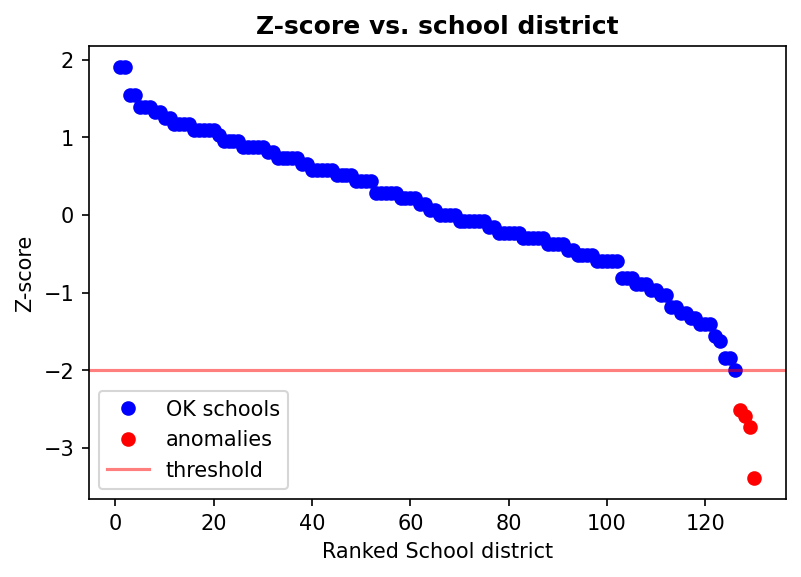

In [7]:
plot_anomaly(ct_test['zscore'], -2)

Finally, get a list of the schools that are anomalies.

In [8]:
zscore_anomalies = ct_test[(ct_test['zscore'] < -2)]
zscore_anomalies

,District,Participation Rate,zscore
50,New Britain,0.40,-2.510660
99,Windham,0.37,-2.731839
121,Eastern Connecticut Regional Educational Servi...,0.39,-2.584386
125,Stamford Academy,0.28,-3.395374


We have found our anomalies, but we still have one thing to do: check our assumption that the data can be modeled approximately as a normal distribution. If this is the case, then we have completed our test. If it isn't, then we cannot connect the z-score with probabilities as we did earlier in this notebook.
First, let's bin the data and see what it looks like as a histogram.

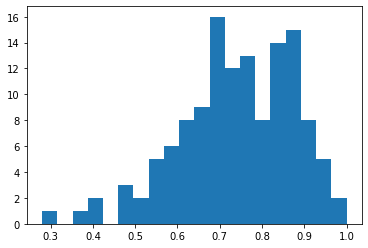

In [34]:
nbins= 20
n_hist, bins_hist, patches_hist = plt.hist(ct_test['Participation Rate'], nbins, density=False,
                           cumulative=False, linewidth=1.0, label='data')

This histogram has two maxima and is skewed left, so it is not likely to be normal.

We can also compare the cumulative distribution function for our data with the CDF of a normal distribution with the same mean and standard deviation of our data.

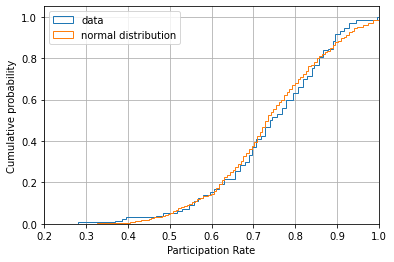

In [35]:
num_bins = 130
normal_dist = [random.gauss(mean_rate, stdev_rate) for _ in range(500)]
n, bins, patches = plt.hist(ct_test['Participation Rate'], num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='data')
plt.hist(normal_dist, num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='normal distribution')
plt.grid(True)
plt.legend(loc='upper left')
axes = plt.gca()
axes.set_xlim([0.2,1.0])
plt.xlabel('Participation Rate')
plt.ylabel('Cumulative probability')
plt.show()

In [36]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Returns the modified z score and Median Absolute Deviation (MAD) from the scores in data.
    The consistency_correction factor converts the MAD to the standard deviation for a given
    distribution. The default value (1.4826) is the conversion factor if the underlying data
    is normally distributed
    """
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

In [37]:
mad_zscore, mad_participation = modified_zscore(ct_test['Participation Rate'])
z_sc_participation = ct_test.assign(zscore_median=mad_zscore)

In [38]:
mod_zscore_anomalies = z_sc_participation[(z_sc_participation['zscore_median'] < -2)]
mod_zscore_anomalies

,District,Participation Rate,zscore,zscore_median
50,New Britain,0.40,-2.510660,-2.585548
55,New London,0.47,-1.994577,-2.060944
99,Windham,0.37,-2.731839,-2.810378
121,Eastern Connecticut Regional Educational Servi...,0.39,-2.584386,-2.660491
125,Stamford Academy,0.28,-3.395374,-3.484869


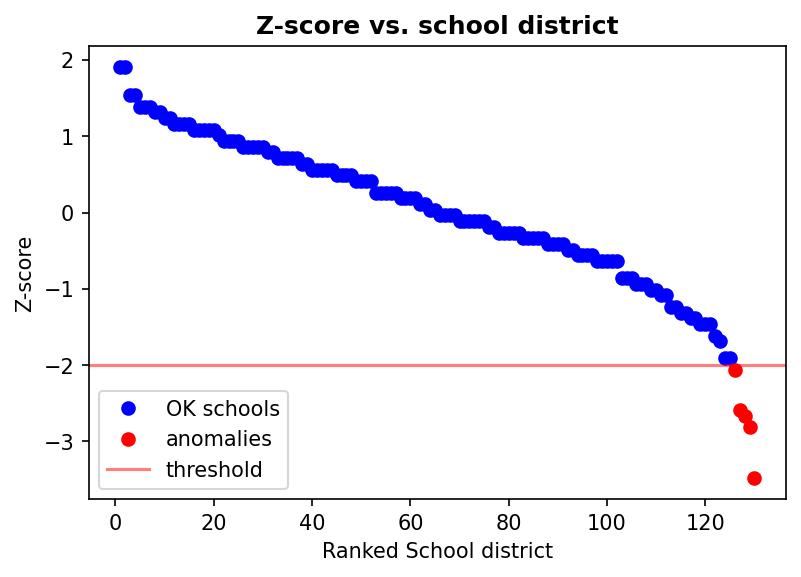

In [39]:
plot_anomaly(z_sc_participation['zscore_median'], -2)

In [40]:
z_sc_participation['zscore_median'].describe()

count    130.000000
mean      -0.033436
std        1.020443
min       -3.484869
25%       -0.618283
50%        0.000000
75%        0.711962
max        1.911057
Name: zscore_median, dtype: float64

In [41]:
z_sc_participation['zscore'].describe()

count    1.300000e+02
mean    -4.208172e-16
std      1.003868e+00
min     -3.395374e+00
25%     -5.753478e-01
50%      3.289322e-02
75%      7.332920e-01
max      1.912911e+00
Name: zscore, dtype: float64

**Question 2**

In [42]:
# First row is a header row, but the header names are cumbersome. 
# Skip first row and manually label
# Encoding ensures that accents in sames are rendered properly 
top_goals = pd.read_csv('../Dataset/world_cup_top_goal_scorers.csv', 
                        encoding='utf-8',  
                        names=['Year', 'Player(s)', 'Goals'], skiprows=1)                                                                                
top_goals

,Year,Player(s),Goals
0,1930,Guillermo Stábile,8
1,1934,Oldřich Nejedlý,5
2,1938,Leônidas,7
3,1950,Ademir,8
4,1954,Sándor Kocsis,11
5,1958,Just Fontaine,13
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4
7,1966,Eusébio,9
8,1970,Gerd Müller,10
9,1974,Grzegorz Lato,7


Once again will start by using the z-score to identify anomalies. As we are interested in the superstars, this time we will have an upper threshold. We choose  z=+2
 . Above this z-score, any player will be labeled as an anomaly.
As before, we calculate the mean and standard deviation.

In [43]:
mean_goals = top_goals['Goals'].mean()
stdev_goals = top_goals['Goals'].std(ddof=0)
print('Mean number of goals is {:.2f}'.format(mean_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

Mean number of goals is 7.05
Standard deviation is 2.15


Calculate the z-score for each player and add the result to the dataframe.

In [44]:
zscore_goals = ss.zscore(top_goals['Goals'], ddof=0)
top_goals = top_goals.assign(zscore=zscore_goals)
top_goals.head(21)

,Year,Player(s),Goals,zscore
0,1930,Guillermo Stábile,8,0.443242
1,1934,Oldřich Nejedlý,5,-0.952971
2,1938,Leônidas,7,-0.022162
3,1950,Ademir,8,0.443242
4,1954,Sándor Kocsis,11,1.839455
5,1958,Just Fontaine,13,2.770264
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4,-1.418375
7,1966,Eusébio,9,0.908647
8,1970,Gerd Müller,10,1.374051
9,1974,Grzegorz Lato,7,-0.022162


Now, modify the previous plotting function to display the results.

In [45]:
def plot_anomaly_goals(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold,color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player Rank')
    plt.ylabel('Z-score')
    plt.show()

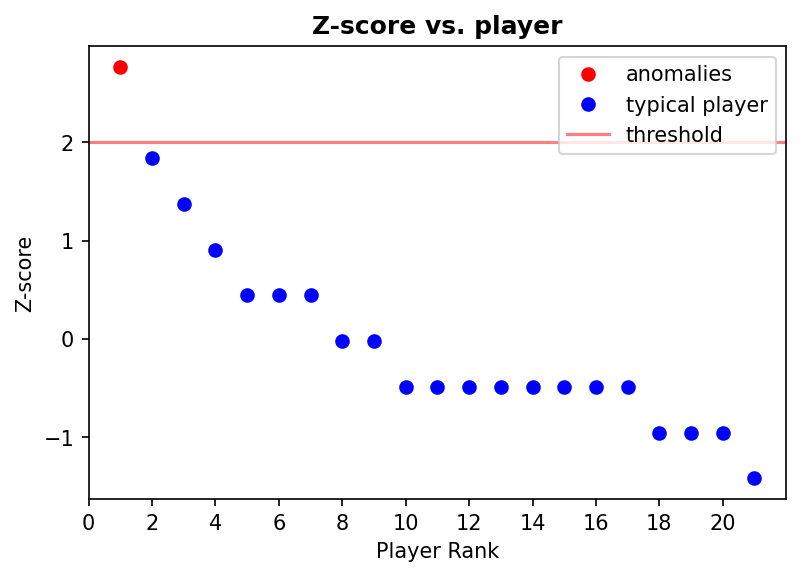

In [46]:
plot_anomaly_goals(top_goals['zscore'], 2)

Only one player is picked out: Just Fontaine.

In [47]:
zscore_anomalies_players = top_goals[(top_goals['zscore'] > 2)]
zscore_anomalies_players

,Year,Player(s),Goals,zscore
5,1958,Just Fontaine,13,2.770264


Fontaine was indeed an amazing player, but clearly our analysis is flawed. By looking at the plot, we see that in 12 out of 21 competitions, the top goalscorer(s) scored less than the mean number of goals (7.05).

Question: What's going on?

Answer: the mean and standard deviation are themselves susceptible to the presence of anomalies. With his 13 goals, the amazing Fontaine is raising the mean so much that most players fall below it. As a result, he becomes the only anomaly.
Let's repeat this analysis with the modified z-score and see what happens.

In [48]:
median_goals = np.median(top_goals['Goals'])
median_goals

6.0

As before, compute the modified z-score for all players then plot and list the results. Note that the threshold remains the same at  y=+2
 .

In [49]:
mod_zscore_goals, mad_goals = modified_zscore(top_goals['Goals'])
top_goals = top_goals.assign(mod_zscore=mod_zscore_goals)

In [50]:
def plot_anomaly_goals_2(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data > threshold)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical player')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player')
    plt.ylabel('Modified z-score')
    plt.show()

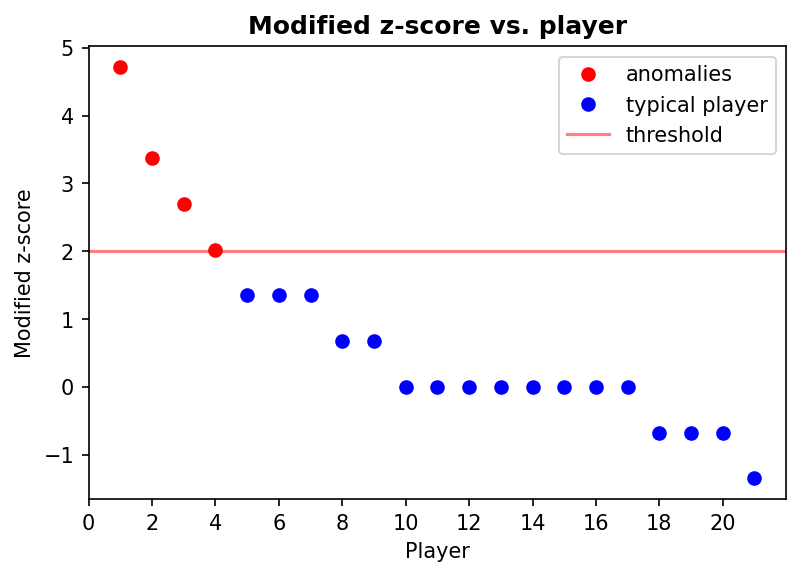

In [51]:
plot_anomaly_goals_2(top_goals['mod_zscore'], 2)

In [52]:
mod_zscore_anomalies_players = top_goals[(top_goals['mod_zscore'] > 2)]
mod_zscore_anomalies_players

,Year,Player(s),Goals,zscore,mod_zscore
4,1954,Sándor Kocsis,11,1.839455,3.372454
5,1958,Just Fontaine,13,2.770264,4.721435
7,1966,Eusébio,9,0.908647,2.023472
8,1970,Gerd Müller,10,1.374051,2.697963


In [53]:
print('The value of MAD is {:.2f}'.format(mad_goals))

The value of MAD is 1.00


In [ ]:
and  k∗MAD
  is 1.48, which is smaller than the standard deviation (2.05). We see that the anomalies have a larger effect on the standard deviation, which depends on the square of the deviation from the mean (MAD depends linearly on the deviation).
Of course, the data for top goal scorers is not normally distributed, so we can't associated probabilities with our scores, but our analysis does show the need to think about the scoring method used with the data.

**Question 3**

In [54]:
import sklearn.datasets as sk_data
import sklearn.neighbors as neighbors
import sys

np.set_printoptions(suppress=True, precision=4)

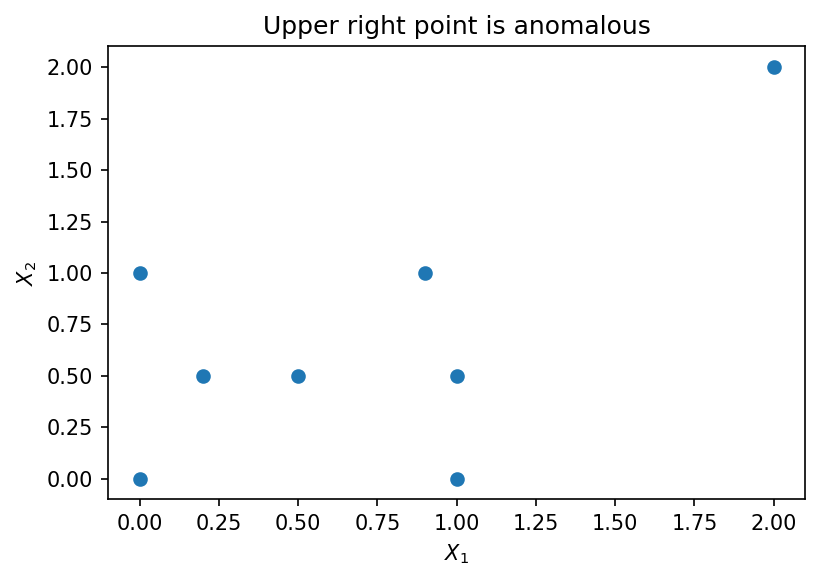

In [55]:
X = np.array([[0.9, 1], [0, 1], [1, 0], [0, 0], [0.5, 0.5], [0.2, 0.5], [1, 0.5], [2, 2]])

plt.figure(dpi=150)
plt.title('Upper right point is anomalous')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.plot(X[:, 0], X[:, 1], 'o');

Let's create a function to visualize a query point and its neighbors more explicitly.

In [56]:
def plot_point_and_k_neighbors(X, highlight_index, n_neighbors=2):
    "Plots the points in X, and shows the n_neighbors of the highlight_index-th point"
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    dist, index = nn.kneighbors()
    
    src_pt = X[highlight_index, :]
    
    plt.figure(dpi=150)
    # draw lines first, so points go on top
    for dest_index in index[highlight_index]:
        dest_pt = X[dest_index, :]
        plt.plot(*list(zip(src_pt, dest_pt)), 'k--')
    plt.plot(X[:, 0], X[:, 1], 'o', label='Not k-neighbors', alpha=0.3)
    plt.plot(*src_pt, 'o', label='The query point')
    plt.plot(X[index[highlight_index], 0], X[index[highlight_index], 1], 'o', label='k-neighbors')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()


Here we can see the 4 points close to the query point (index of 0 in our data) are relatively close. Let's look at the anomalous point in the upper right (this point has an index of 7):

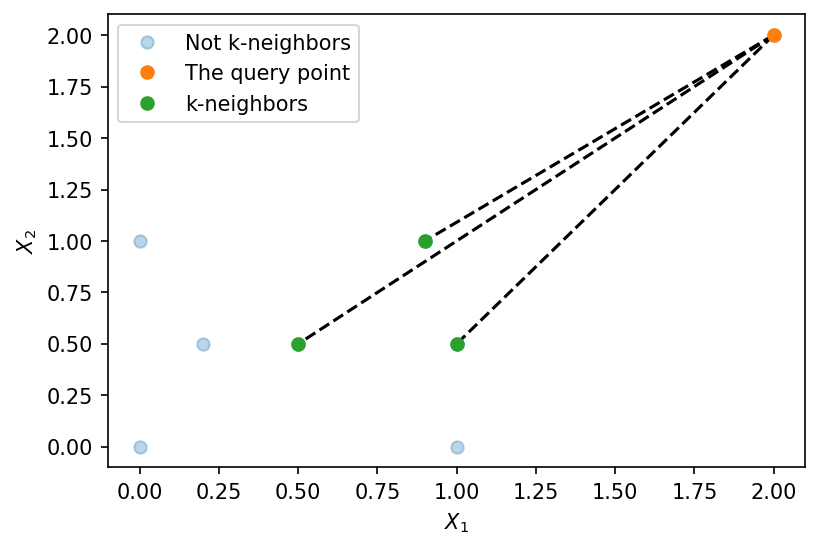

In [57]:
plot_point_and_k_neighbors(X, 7, n_neighbors=3)

We can see in this case all of the 4-nearest neighbors to our point are far away, so it seems reasonably unambiguous to call this point an anomaly.
Let's add one more point next to the anomaly, and see how choosing "k" and the scoring function affects things.

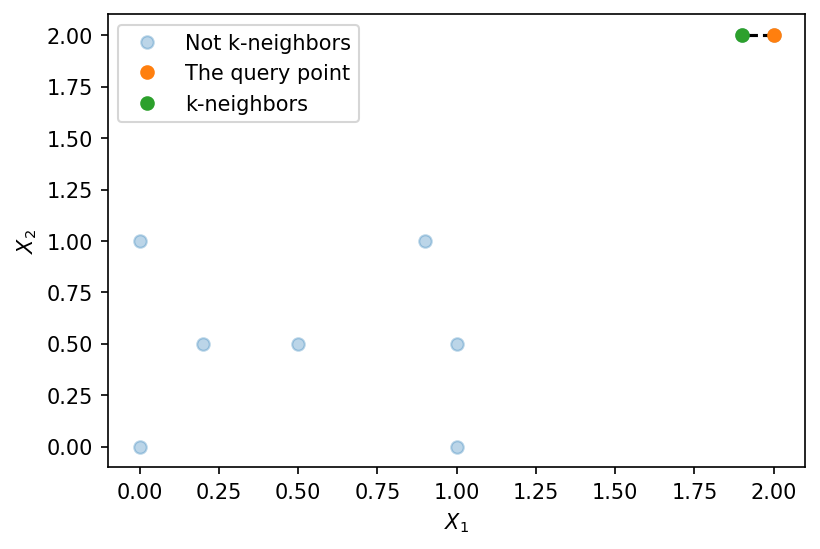

In [58]:
# Toy dataset with two adjacent anomalies
X2 = np.concatenate([X, [[1.9, 2.0]]])

# Look at nearest neighbor (k=1)
plot_point_and_k_neighbors(X2, 7, n_neighbors=1)

In [59]:
def print_ranked_scores(obs, scores):
    scores_and_obs = sorted(zip(scores, obs), key=lambda t: t[0], reverse=True)
    print('Rank  Point\t\tScore')
    print('------------------------------')
    for index, score_ob in enumerate(scores_and_obs):
        score, point = score_ob
        print(f'{index+1:3d}.  {point}\t\t{score:6.4f}')

# Look at the outliers using 3 neighbors

In [60]:
# LOF for KNN 3

import sklearn.neighbors as neighbors
lof = neighbors.LocalOutlierFactor(n_neighbors=3, contamination='auto')
lof.fit(X2)
sk_lof = -lof.negative_outlier_factor_
print_ranked_scores(X2, sk_lof)

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8608
  2.  [1.9 2. ]		1.8293
  3.  [0.2 0.5]		1.2154
  4.  [1.  0.5]		1.2091
  5.  [0. 0.]		1.0333
  6.  [0. 1.]		1.0120
  7.  [1. 0.]		0.9554
  8.  [0.9 1. ]		0.8891
  9.  [0.5 0.5]		0.8272


In [61]:
#LOF for KNN 1

def do_nn_outlier_scores(obs, n_neighbors=1):
    """
    Gives the score of a point as the distance from point to its k-th nearest neighbor.
    Larger score means more likely to be an outlier
    """
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    print(dists)
    scores = dists[:,-1]
    return scores

# Test 
print_ranked_scores(X2, do_nn_outlier_scores(X2, 1))

[[0.5099]
 [0.5385]
 [0.5   ]
 [0.5385]
 [0.3   ]
 [0.3   ]
 [0.5   ]
 [0.1   ]
 [0.1   ]]
Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.5385
  2.  [0. 0.]		0.5385
  3.  [0.9 1. ]		0.5099
  4.  [1. 0.]		0.5000
  5.  [1.  0.5]		0.5000
  6.  [0.5 0.5]		0.3000
  7.  [0.2 0.5]		0.3000
  8.  [2. 2.]		0.1000
  9.  [1.9 2. ]		0.1000


**Question 4**

In [62]:
def do_nn_avg_scores(obs, n_neighbors=1):
  
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    return np.mean(dists , axis=1)

# Test 
print_ranked_scores(X2,do_nn_avg_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.1298
  2.  [1.9 2. ]		1.0878
  3.  [0. 0.]		0.7485
  4.  [1. 0.]		0.7168
  5.  [0. 1.]		0.7152
  6.  [0.9 1. ]		0.6701
  7.  [1.  0.5]		0.5033
  8.  [0.5 0.5]		0.4801
  9.  [0.2 0.5]		0.4590


In [63]:
from scipy.stats import hmean
def do_nn_harm_scores(obs, n_neighbors=1):
  
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    return hmean(dists , axis=1)

# Test 
print_ranked_scores(X2, do_nn_harm_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [0. 0.]		0.7024
  2.  [0. 1.]		0.6846
  3.  [1. 0.]		0.6705
  4.  [0.9 1. ]		0.6403
  5.  [1.  0.5]		0.5033
  6.  [0.5 0.5]		0.4351
  7.  [0.2 0.5]		0.4257
  8.  [2. 2.]		0.2672
  9.  [1.9 2. ]		0.2660


**Question 5**

In [64]:
def lof_method(obs, n_neighbors=2):
    neigh = neighbors.NearestNeighbors(n_neighbors=2).fit(obs)
    
    #Return indices of and distances to the neighbors of each point
    topk_dist, my_kneigh = neigh.kneighbors()
    
    # Create list of distances of furthest (kth) neighbor 
    k_dist = topk_dist[:,-1]
 
    # Reachability distance: maximum of true distance between query neighbor and query point
    # and distance to kth nearest neighbor of query neighbor
    reach = np.maximum(topk_dist, k_dist[my_kneigh])
    
    # Local reacability density is reciprocal of average reachability distance
    lrd = 1.0 / np.mean(reach, axis=1)
    
    # Local outlier factor is given by
    # average local density of neighbors / local density of query point
    lrd_ratios = lrd[my_kneigh] / lrd[:, np.newaxis]
    lof = np.mean(lrd_ratios, axis=1)
    
    return lof